# Project

This notebook will go though the various aspects of iteration through the various python scripts used as part of this project. 

https://www.met.ie/climate/available-data/historical-data

## Section X - Importing modules and initia data processing

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import python_scripts.project_functions as pf
import python_scripts.data_processing as dp 

plt.style.use('seaborn-v0_8')

In [2]:
# zipped_data = 'data\\hly2375.zip'
# dst_dir = 'data\\'

# # Unzip the combined zip file
# with zipfile.ZipFile(zipped_data, 'r') as zip_ref:
#     zip_ref.extractall(dst_dir)

In [3]:
# pf.extract_zip('data\\hly2375.zip', 'data\\')

import data

In [4]:
# setting low_memory to false to stop guessing of column dtypes as this is memory intensive
path = 'data\\hly2375.csv'
data = pd.read_csv(path, skiprows=22, low_memory=False)

#data = data_.sample(n=25000, random_state=42)
print(data.shape)
print(data.head())

(597898, 21)
                date  ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
0  16-sep-1956 15:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1  16-sep-1956 16:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
2  16-sep-1956 17:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
3  16-sep-1956 18:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
4  16-sep-1956 19:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

   ...  ind.3  wdsp ind.4  wddir ww  w  sun    vis clht clamt  
0  ...      1     0     1      0  1  2  0.1  16000  200     5  
1  ...      1     0     1      0  1  1  0.1  24000  999     4  
2  ...      1     0     1      0  3  1  0.4  19000   90     5  
3  ...      1     0     1      0  1  1  0.0  30000   45     4  
4  ...      1     0     1      0  3  2  0.0  28000   40     7  

[5 rows x 21 columns]


In [5]:
print(np.min(data.date),np.max(data.date))
# the first year is 1956, and the last date is in December 2024 so need to add the date column as the index. 

01-apr-1957 00:00 31-oct-2024 23:00


Several data processing operations need to be completed, and initially the `date` was changed to a datetime oject and then some data extration (such as decades and season) was done. Then a `DataProcessor` class was added to make some operations easier, but then some of the functions didn't work as well with `.strftime` . For this, data extraction was done to the `date` column before changing it to a datetime object. 

Season was also extracted. While a `pd.resample` could be used, this only has quarters and not true seasons. Using similar data from Met Éireann, [Murphy et al., 2023](https://www.sciencedirect.com/science/article/pii/S2212094723000610) break down the seasons into from the months below;
- Winter: Dec, Jan, and Feb
- Spring: Mar, Apr, and May
- Summer: Jun, Jul, and Aug
- Autumn: Sep, Oct, and Nov

Data extraction operations include
- Capitilizing name of month 
- Extracting month and season 
- Extracting year and decade

In [6]:
# firstly capitalise the first letter of month

# Apply the function to the date column
data['date'] = data['date'].apply(pf.capitalize_month)

print(data.head())

                date  ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
0  16-Sep-1956 15:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1  16-Sep-1956 16:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
2  16-Sep-1956 17:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
3  16-Sep-1956 18:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
4  16-Sep-1956 19:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

   ...  ind.3  wdsp ind.4  wddir ww  w  sun    vis clht clamt  
0  ...      1     0     1      0  1  2  0.1  16000  200     5  
1  ...      1     0     1      0  1  1  0.1  24000  999     4  
2  ...      1     0     1      0  3  1  0.4  19000   90     5  
3  ...      1     0     1      0  1  1  0.0  30000   45     4  
4  ...      1     0     1      0  3  2  0.0  28000   40     7  

[5 rows x 21 columns]


Setting the `date` column to be index. In a similar fashion to [here](https://github.com/EllenMcG/PFDA/blob/main/assignments/assignment_6_weather.ipynb).

In [7]:
# Apply the function to add month and season columns
data = pf.add_month_and_season(data)

In [8]:
data = pf.add_year_and_decade(data)
# print(data.head())


In [9]:
# setting index to date
processor = dp.DataProcessor(data)
processor.convert_to_datetime('date')
print(data.head())

                     ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
date                                                                           
1956-09-16 15:00:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1956-09-16 16:00:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
1956-09-16 17:00:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
1956-09-16 18:00:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
1956-09-16 19:00:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

                        msl  ...  ww  w  sun    vis clht clamt month  season  \
date                         ...                                               
1956-09-16 15:00:00  1026.7  ...   1  2  0.1  16000  200     5   Sep  Autumn   
1956-09-16 16:00:00  1026.6  ...   1  1  0.1  24000  999     4   Sep  Autumn   
1956-09-16 17:00:00  1026.4  ...   3  1  0.4  19000   90     5   Sep  Autumn   
1956-09-16 18:00:00  1026.5  ...   1  1

## Section 1 - Comparison with a subset of data (used for testing)

While a `pd.resample` could be used, this only has quarters and not true seasons. Using similar data from Met Éireann, [Murphy et al., 2023](https://www.sciencedirect.com/science/article/pii/S2212094723000610) break down the seasons into from the months below;
- Winter: Dec, Jan, and Feb
- Spring: Mar, Apr, and May
- Summer: Jun, Jul, and Aug
- Autumn: Sep, Oct, and Nov



In [10]:
data_subsampled = data.sample(n=1000, random_state=42)
print(data_subsampled.head())
print(data_subsampled.shape)

                     ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
date                                                                           
1963-04-13 11:00:00    0   0.2      0   7.8      0   5.8    3.0    7.6    72   
1979-08-19 04:00:00    2   0.0      0  12.6      0  11.6   11.0   12.8    88   
1970-06-12 23:00:00    2   0.0      0  14.4      0  14.1   14.0   15.8    97   
2001-02-16 15:00:00    0   0.0      0   8.0      0   6.6    4.8    8.6    80   
1962-01-22 08:00:00    0   0.0      0   5.6      0   3.5    0.0    6.2    68   

                        msl  ...  ww   w  sun    vis clht clamt month  season  \
date                         ...                                                
1963-04-13 11:00:00  1009.1  ...  25   8  0.8  19000   19     6   Apr  Spring   
1979-08-19 04:00:00  1019.7  ...  50   5  0.0   3000    2     8   Aug  Summer   
1970-06-12 23:00:00  1018.6  ...  50   5  0.0   3200    4     8   Jun  Summer   
2001-02-16 15:00:00  1037.2  ...  

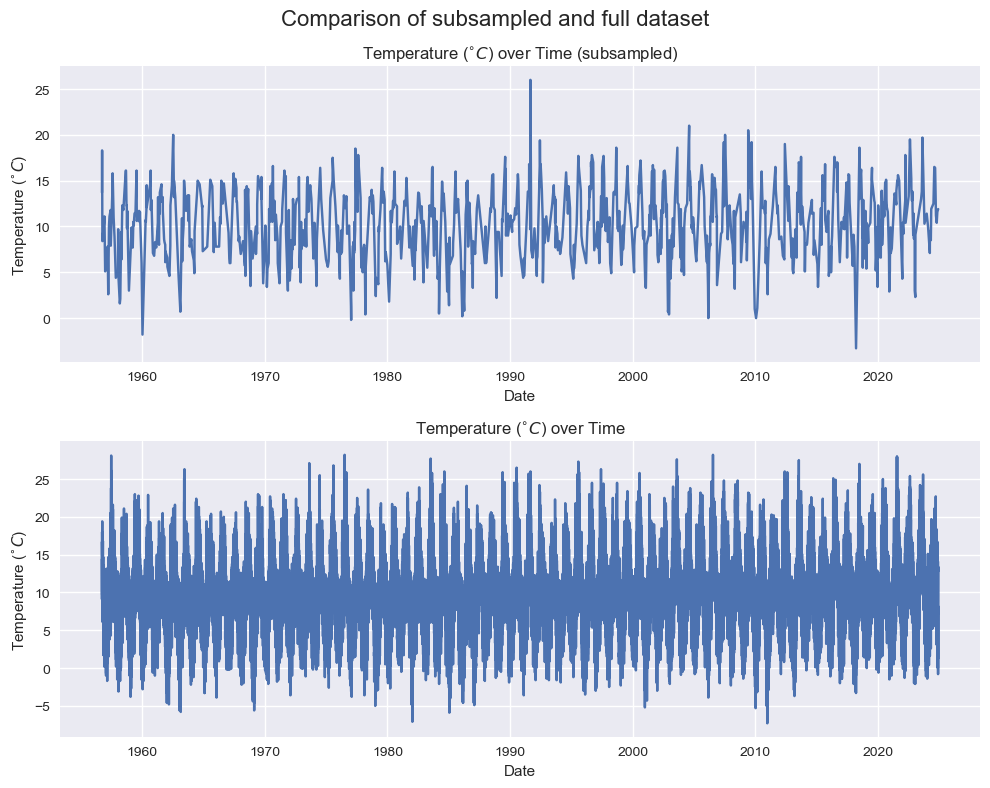

In [11]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

fig.suptitle('Comparison of subsampled and full dataset', fontsize=16)

sns.lineplot(data=data_subsampled,x=data_subsampled.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_title('Temperature ($^{\circ}C$) over Time (subsampled)')

sns.lineplot(data=data,x=data.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_title('Temperature ($^{\circ}C$) over Time')

plt.tight_layout();

### Section 1.1 Subsampling 
There is a seasonality element to this plot, which is easier to see in the subsampled data. There is too much data in the full dataset to view these processes. A `.resampe` method will be used on the origional dataset `data` and downsample it to month. 

The resampling method failed as some columns are of the type object and returned the error `TypeError: agg function failed [how->mean,dtype->object]` which can be fixed using some of the `DataProcessor` methods. 

Before this, the whitespace in some columns needed to be fixed (this will be investigated with `wdsp` first).


In [12]:
# investigation of wdsp column

unique = data['wdsp'].unique()
print(unique)


['0' '9' '7' '4' '6' '8' '11' '12' '10' '5' '13' '14' '15' '18' '19' '17'
 '16' '21' '24' '22' '26' '20' '23' '3' '2' '1' '25' '36' '38' '34' '37'
 '29' '27' '28' '31' '30' '32' '33' '35' '41' '45' '49' '48' '43' '39'
 '40' '44' '58' '63' '47' '59' '56' '42' '46' '51' '50' '53' '55' '52'
 '54' '57' ' ']


In [13]:
missing_data = data['wdsp'].isnull().sum()
print(missing_data)


0


Looking at the below image, there is white space at the last entry, but the above code using `.isnull()` does not pick it up as a missing value as the rows with white space does not have a `NaN` value. 

![image of white space for a in place of data](img/whitespace.png)

The below code checks for whitespace in the `wdsp` column and prints it out. Since there is only one value missing a `NaN` value can be inserted and checked with the `.isnull` method. 

```python
missing_whtspace = data['wdsp'].str.startswith(' ').sum()
print(missing_whtspace)
1
```

This `NaN` value can then be filled, in this case `.bfill` was used given so little values are actually missing such a big dataset (>0.5 million rows). 

In [14]:
missing_whtspace = data['wdsp'].str.startswith(' ').sum()
print(missing_whtspace)

1


In [18]:
data['wdsp'] = np.where(data['wdsp'].str.startswith(' '), np.nan, data['wdsp'])
is_null = data['wdsp'].isnull().sum()
print(is_null)

1


In [19]:
data['wdsp'] = data['wdsp'].bfill()

In [20]:
unique_2 = data['wdsp'].unique()
print(unique_2)

['0' '9' '7' '4' '6' '8' '11' '12' '10' '5' '13' '14' '15' '18' '19' '17'
 '16' '21' '24' '22' '26' '20' '23' '3' '2' '1' '25' '36' '38' '34' '37'
 '29' '27' '28' '31' '30' '32' '33' '35' '41' '45' '49' '48' '43' '39'
 '40' '44' '58' '63' '47' '59' '56' '42' '46' '51' '50' '53' '55' '52'
 '54' '57']


In [21]:
# convert to int
processor.convert_to_int('wdsp')

#### Section 1.1.1 Data processing of missing data

Further investigation of object columns showed the following;
- `wwdir` was missing only 8 values.
- `ww` missing > 100000 rows of data (108018). Backfilling this would not be an option so a method of impution would be needed. Since this classification column won't be used this can be deleted.
- `w` missing > 100000 rows of data (108018). Backfilling this would not be an option so a method of impution would be needed. Since this classification column won't be used this can be deleted. The same rows missing for `ww` are missing for `w`.
- `vis` is missing > 100000 rows of data (108052). This is not a classification column, and would be an interesting column for modelling. 
- `clht` is missing > 100000 rows of data (108042). As above, backfilling is used. The `KeyHourly.txt` file shows that values decoded as 999 are none, so this needs to be converted to 0.
- `clamt` is missing > 100000 rows of data (108042). As above, backfilling is used. 
- `sun` is missing > 100000 rows of data (107952)

These columns are missing a lot of data (`wwdir`, `vis`,`clht`, `clamt`, and `sun`) that backfilling would not be an option so a method of impution would be needed. Since this classification column won't be used this can be deleted. A lot of these rows are missing the same columns, so may not be missing at random. Backfilling would be more deserible than forward filling, but given 1/6th of data is missing a more robust imputation method would be good. Given the vaules have a big range, dropping these columns may be more desirable.

Both `ww` and `w` can be dropped as they are classification columns and won't be used further. 

Data shape has being reduced from 597898 to 489845 (108053 or 18.1%) after operations of white space. 


```python
data.shape
(597898, 21)

columns_to_check = ['sun', 'vis', 'clht', 'clamt', 'wddir'] 

for column in columns_to_check:
     data = data[data[column] != ' ']

data.shape
(489845, 24)
```

Further information and cleaning of whitespace is documented within `research.ipynb`. 

In [22]:
columns_to_check = ['sun', 'vis', 'clht', 'clamt', 'wddir'] 

for column in columns_to_check:
     data = data[data[column] != ' ']

# Now 'data' is filtered for all specified columns

In [23]:
# replace values of 999 with 0 for clht
data['clht'] = np.where(data['clht'] == '999', '0', data['clht'])

In [24]:
data['sun'] = pd.to_numeric(data['sun'])

In [25]:
columns_to_check_int = ['vis', 'clht', 'clamt', 'wddir'] 
for column in columns_to_check_int:
    data[column] = data[column].astype(int)

In [ ]:
# drop columns w and ww as classificaiton columns are not needed
data.drop(columns=['w','ww'], axis=1)

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,...,ind.4,wddir,sun,vis,clht,clamt,month,season,year,decade
date,,,,,,,,,,,,,,,,,,,,,
1956-09-16 15:00:00,0,0.0,0,14.4,0,12.1,10.0,12.4,76,1026.7,...,1,0,0.1,16000,200,5,Sep,Autumn,1956,1950s
1956-09-16 16:00:00,0,0.0,0,13.9,0,11.6,9.4,11.9,75,1026.6,...,1,0,0.1,24000,0,4,Sep,Autumn,1956,1950s
1956-09-16 17:00:00,0,0.0,0,14.2,0,12.0,10.0,12.3,76,1026.4,...,1,0,0.4,19000,90,5,Sep,Autumn,1956,1950s
1956-09-16 18:00:00,0,0.0,0,13.0,0,11.6,10.0,12.6,85,1026.5,...,1,0,0.0,30000,45,4,Sep,Autumn,1956,1950s
1956-09-16 19:00:00,0,0.0,0,12.6,0,11.7,11.1,13.1,90,1026.8,...,1,0,0.0,28000,40,7,Sep,Autumn,1956,1950s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-07 20:00:00,0,0.0,0,14.7,0,13.7,12.9,14.9,89,1019.9,...,2,30,0.4,75000,0,2,Aug,Summer,2012,2010s
2012-08-07 21:00:00,3,0.0,0,13.7,0,12.8,12.0,14.1,90,1020.7,...,2,40,0.0,75000,0,3,Aug,Summer,2012,2010s
2012-08-07 22:00:00,3,0.0,0,13.5,0,12.9,12.4,14.4,93,1020.6,...,2,50,0.0,75000,0,3,Aug,Summer,2012,2010s


In [27]:
data.describe()

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir,sun,vis,clht,clamt,year
count,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000
mean,0.802744,0.134879,0.006408,10.117657,0.020604,8.863502,7.456944,10.718319,84.054327,1012.513522,1.329559,12.880134,1.330425,195.788402,0.149068,25174.721402,31.747683,5.866409,1984.155882
std,1.164676,0.486246,0.079794,4.050031,0.267857,3.901619,4.318526,3.049523,10.141021,13.012732,0.860392,7.054515,0.860978,95.052932,0.311318,14180.209688,46.225745,2.308052,16.140151
min,0.000000,0.000000,0.000000,-7.300000,0.000000,-7.600000,-17.700000,2.400000,29.000000,943.200000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,1956.000000
25%,0.000000,0.000000,0.000000,7.400000,0.000000,6.100000,4.300000,8.300000,77.000000,1004.600000,0.000000,8.000000,0.000000,130.000000,0.000000,15000.000000,3.000000,4.000000,1970.000000
50%,0.000000,0.000000,0.000000,10.200000,0.000000,9.000000,7.900000,10.600000,86.000000,1013.800000,2.000000,12.000000,2.000000,210.000000,0.000000,24000.000000,20.000000,7.000000,1984.000000
75%,2.000000,0.000000,0.000000,13.100000,0.000000,11.800000,10.800000,12.800000,92.000000,1021.800000,2.000000,17.000000,2.000000,270.000000,0.000000,30000.000000,38.000000,8.000000,1998.000000
max,6.000000,25.900000,1.000000,28.200000,6.000000,22.900000,21.300000,25.400000,100.000000,1050.900000,6.000000,63.000000,6.000000,360.000000,1.000000,75000.000000,300.000000,8.000000,2012.000000


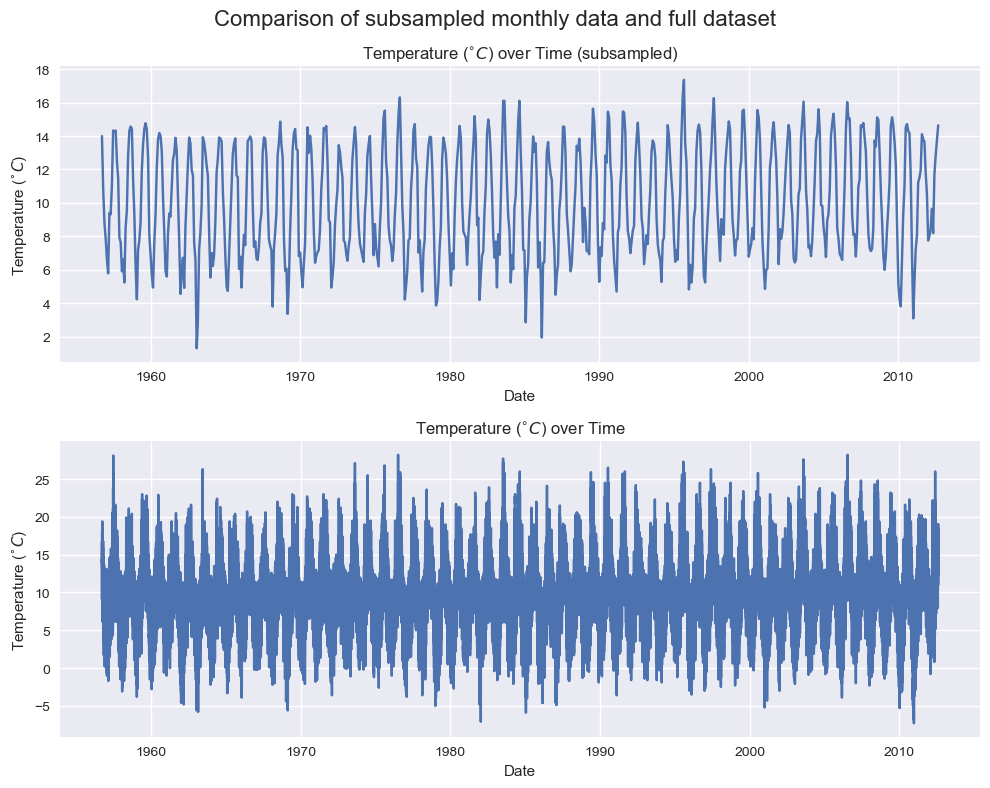

In [43]:
# resampling every month 
# adding in a second column as if sample on one column it will be a pd.Series
# and season is still an object so cant be resampled to mean
data_monthly = data[['sun','temp']].resample('ME').mean()

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

fig.suptitle('Comparison of subsampled monthly data and full dataset', fontsize=16)
sns.lineplot(data=data_monthly,x=data_monthly.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_title('Temperature ($^{\circ}C$) over Time (subsampled)')
sns.lineplot(data=data,x=data.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_title('Temperature ($^{\circ}C$) over Time')

plt.tight_layout();

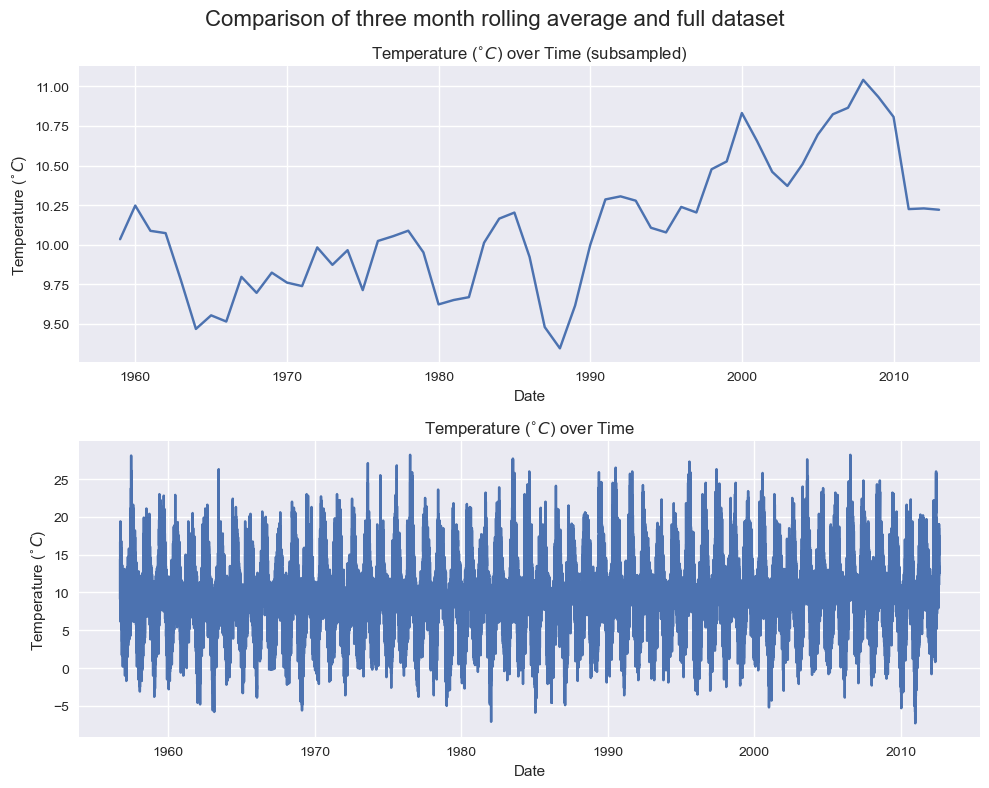

In [77]:
# resampling every month with rolling average of 3 months
# adding in a second column as if sample on one column it will be a pd.Series
# and season is still an object so cant be resampled to mean
data_monthly['temp_moving_avg'] = data_monthly['temp'].rolling(window=3).mean()

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

fig.suptitle('Comparison of three month rolling average and full dataset', fontsize=16)
sns.lineplot(data=data_monthly,x=data_monthly.index,y='temp_moving_avg', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_title('Temperature ($^{\circ}C$) over Time (subsampled)')
sns.lineplot(data=data,x=data.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_title('Temperature ($^{\circ}C$) over Time')

plt.tight_layout();

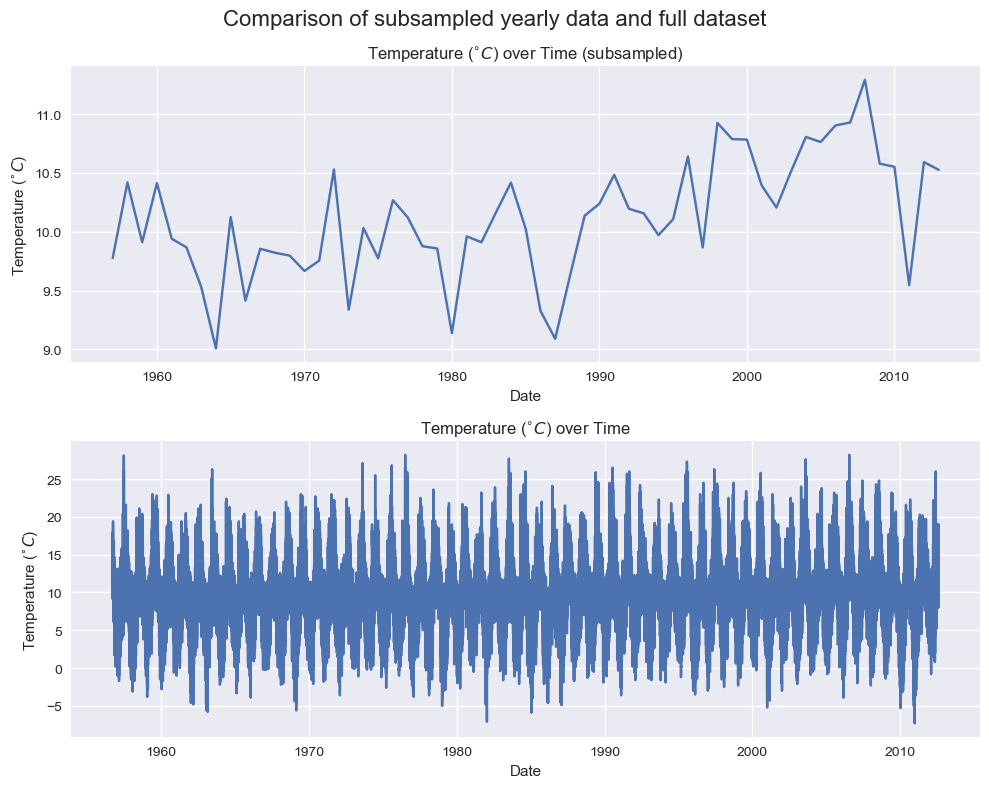

In [92]:
# resampling every year
# adding in a second column as if sample on one column it will be a pd.Series
# and season is still an object so cant be resampled to mean
data_yearly = data[['sun','temp']].resample('YE').mean()

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

fig.suptitle('Comparison of subsampled yearly data and full dataset', fontsize=16)
sns.lineplot(data=data_yearly,x=data_yearly.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_title('Temperature ($^{\circ}C$) over Time (subsampled)')
sns.lineplot(data=data,x=data.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_title('Temperature ($^{\circ}C$) over Time')

plt.tight_layout();

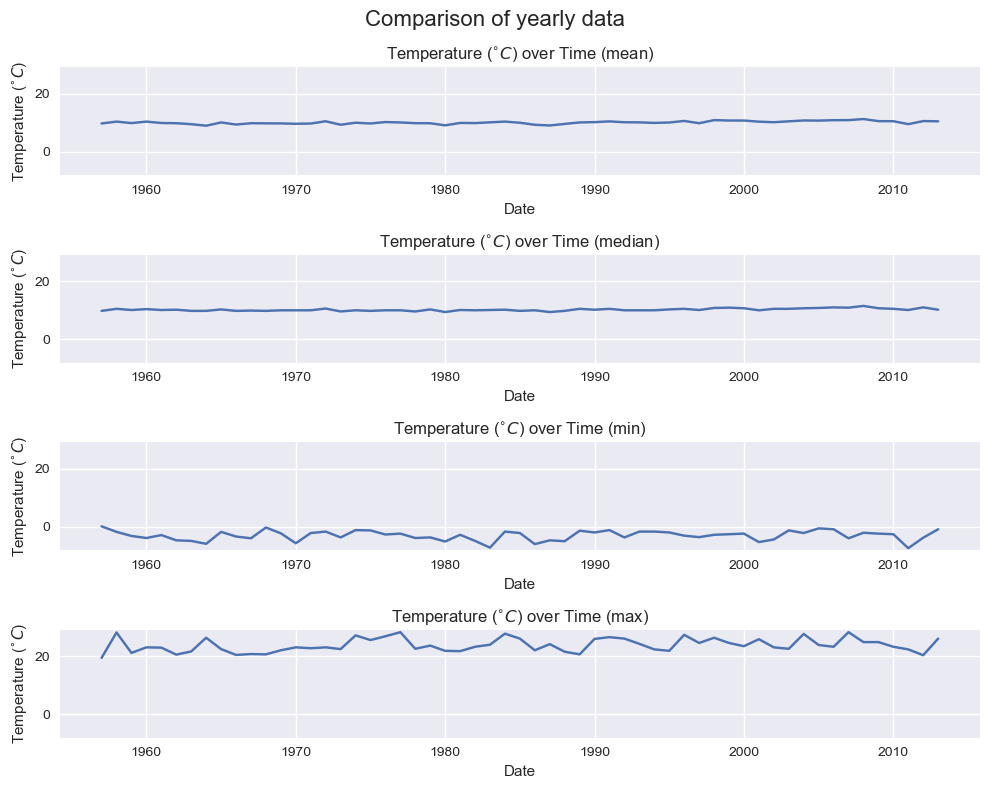

In [184]:
# resampling every year showing mean, median, min, and max
data_yearly_mean = data[['sun','temp']].resample('YE').mean()
data_yearly_median = data[['sun','temp']].resample('YE').median()
data_yearly_min = data[['sun','temp']].resample('YE').min()
data_yearly_max = data[['sun','temp']].resample('YE').max()

# Create a figure and two subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

fig.suptitle('Comparison of yearly temperature data', fontsize=16)
sns.lineplot(data=data_yearly_mean,x=data_yearly_mean.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_ylim([-8, 29])
ax1.set_title('Temperature ($^{\circ}C$) over Time (mean)')

sns.lineplot(data=data_yearly_median,x=data_yearly_median.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_ylim([-8, 29])
ax2.set_title('Temperature ($^{\circ}C$) over Time (median)')

fig.suptitle('Comparison of yearly data', fontsize=16)
sns.lineplot(data=data_yearly_min,x=data_yearly_min.index,y='temp', ax=ax3)
ax3.set_ylabel('Temperature ($^{\circ}C$)')
ax3.set_xlabel('Date')
ax3.set_ylim([-8, 29])
ax3.set_title('Temperature ($^{\circ}C$) over Time (min)')

fig.suptitle('Comparison of yearly data', fontsize=16)
sns.lineplot(data=data_yearly_max,x=data_yearly_max.index,y='temp', ax=ax4)
ax4.set_ylabel('Temperature ($^{\circ}C$)')
ax4.set_xlabel('Date')
ax4.set_ylim([-8, 29])
ax4.set_title('Temperature ($^{\circ}C$) over Time (max)')

plt.tight_layout();

g 

## Section 2 - Seasonality 

Adding decades for plotting 

In [185]:
# Plotting the temperature by season over time (decades)
# data = pf.add_year_and_decade(data)

## Section 3 - Power Analysis 

Power can now be calculated. `wdsp` was already converted to an datatype of type `int` (see Section X.XXXX)

In [186]:
# processor.convert_to_int('wdsp')

data['power'] = pf.calculate_power(data['wdsp'])

# adding converted wdsp column (from knots to m/s) 
data['wdsp_ms'] = data['wdsp'] * 0.514444 # small calc so not added to cleaning functions
# data['power'] = pf.calculate_power(data['wdsp'].astype(int))
print(data.head())

                     ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
date                                                                           
1956-09-16 15:00:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1956-09-16 16:00:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
1956-09-16 17:00:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
1956-09-16 18:00:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
1956-09-16 19:00:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

                        msl  ...  sun    vis  clht  clamt month  season  year  \
date                         ...                                                
1956-09-16 15:00:00  1026.7  ...  0.1  16000   200      5   Sep  Autumn  1956   
1956-09-16 16:00:00  1026.6  ...  0.1  24000     0      4   Sep  Autumn  1956   
1956-09-16 17:00:00  1026.4  ...  0.4  19000    90      5   Sep  Autumn  1956   
1956-09-16 18:00:00  1026.5  ...  

In [187]:
a = data.groupby('season')['power'].agg(['mean','median','std'])
print(a)

              mean     median         std
season                                   
Autumn  151.469691  73.284218  238.010493
Spring  130.554012  57.640022  198.624408
Summer   88.131383  44.397494  126.883863
Winter  201.664570  91.530221  323.518054


### Section X - Logisic Regression

In [188]:
 

# log_reg = dp.BinaryLogisticRegression(df, 'target')
# log_reg.preprocess_data()
# log_reg.train_model()
# log_reg.evaluate_model()


## Final exported dataset

In [189]:
# data.to_csv('data\\hly2375_cleaned.csv', index=True)

In [190]:
# data_condensed['year'] = data_condensed.index.year.astype('str')
# print(data_condensed.info())

### **References**
[Murphy et al., 2023](https://www.sciencedirect.com/science/article/pii/S2212094723000610)